# Risk management for Travel Insurance Company

### Problem Description
Insurance companies take risks over customers. Risk management is a very important aspect of the insurance industry. Insurers consider every quantifiable factor to develop profiles of high and low insurance risks. Insurers collect vast amounts of information about policyholders and analyze the data.

As a Data scientist in an insurance company, you need to analyze the available data and predict whether to sanction the insurance or not.

### Dataset Description
A zipped file containing train, test and sample submission files are given. The training dataset consists of data corresponding to 52310 customers and the test dataset consists of 22421 customers. Following are the features of the dataset

Target: Claim Status (Claim)

Name of agency (Agency)

Type of travel insurance agencies (Agency.Type)

Distribution channel of travel insurance agencies (Distribution.Channel)

Name of the travel insurance products (Product.Name)

Duration of travel (Duration)

Destination of travel (Destination)

Amount of sales of travel insurance policies (Net.Sales)

The commission received for travel insurance agency (Commission)

Age of insured (Age)

The identification record of every observation (ID)

Evaluation Metric
The evaluation metric for this task will be precision_score. Read up about it more here.

### Submission Format
The user has to submit a csv file with the ID and Claim label. Sample submission file has been given to you. You can refer the sample submission file.

In [1]:
# Import Libraries
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,accuracy_score,classification_report,roc_curve,precision_score, r2_score
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

In [46]:
# Load the data by path
def LoadData(path):
    data = pd.read_csv(path,delimiter=',')
    data.drop(['ID'],1, inplace = True)
    return data

In [47]:
path = 'data/train.csv'
df = LoadData(path)
print('Shape of the data is: ',df.shape)
df.head()

Shape of the data is:  (52310, 10)


,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                52310 non-null  object 
 1   Agency Type           52310 non-null  object 
 2   Distribution Channel  52310 non-null  object 
 3   Product Name          52310 non-null  object 
 4   Duration              52310 non-null  int64  
 5   Destination           52310 non-null  object 
 6   Net Sales             52310 non-null  float64
 7   Commision (in value)  52310 non-null  float64
 8   Age                   52310 non-null  int64  
 9   Claim                 52310 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB


In [49]:
# Function to identify numeric features
def numeric_categorical_features(dataset):
    cols = dataset.columns.tolist()
    num_cols = dataset.select_dtypes(include=np.number).columns.tolist()
    cat_cols = dataset.select_dtypes(exclude=np.number).columns.tolist()
    return cols, num_cols, cat_cols

In [50]:
cols, num_cols, cat_cols = numeric_categorical_features(df)
print("Number Features:")
print(len(cols))
print("All Features list:")
print(cols)
print("===="*20)
print("Number of Numeric Features:")
print(len(num_cols))
print("Numeric Features list:")
print(num_cols)
print("===="*20)
print("Number of Categorical Features:")
print(len(cat_cols))
print("Categorical Features list:")
print(cat_cols)
print("===="*20)

Number Features:
10
All Features list:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age', 'Claim']
Number of Numeric Features:
5
Numeric Features list:
['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Claim']
Number of Categorical Features:
5
Categorical Features list:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']


In [51]:
# Function to identify the number of missing values in every feature
def missing_data(dataset):
    print("Missing values in all Features: ")
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total count', 'Percent'])
    print(missing_data)

#Check for Class Imbalance
def class_imbalance(target):
    print("Class Imbalance for Target Feature: ")
    values_count = (target.value_counts())
    class_perc = (target.value_counts()/target.value_counts().sum())*100
    imbalance_data = pd.concat([values_count, class_perc], axis=1, keys=['Count', 'Percent'])
    print(imbalance_data)


Text(0.5, 0, 'Categories')

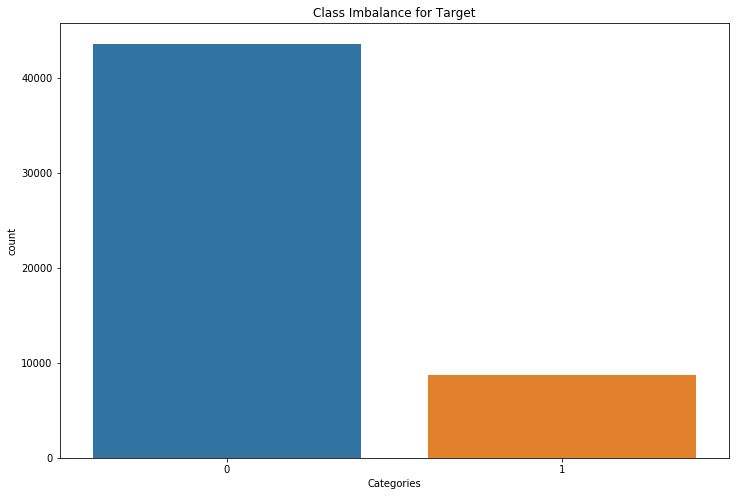

In [52]:
plt.figure(figsize=(12,8))
sns.countplot(df['Claim'])
plt.title('Class Imbalance for Target')
plt.xlabel('Categories')
# plt.savefig('class_imbalance.png')

In [53]:
class_imbalance(df['Claim'])

Class Imbalance for Target Feature: 
   Count    Percent
0  43590  83.330147
1   8720  16.669853


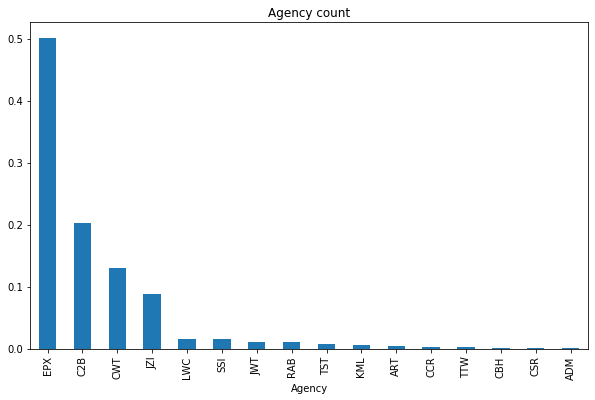

In [54]:
plt.figure(figsize=(10,6))
df['Agency'].value_counts(normalize=True).plot(kind = 'bar')
plt.title('Agency count')
plt.xlabel('Agency')
plt.show()
# plt.savefig('class_imbalance.png')

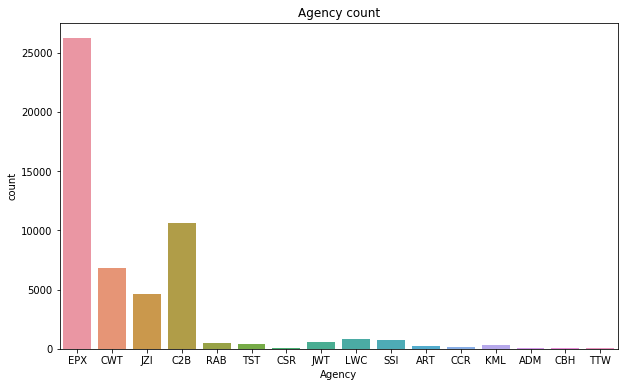

In [55]:
plt.figure(figsize=(10,6))
sns.countplot(df['Agency'])
plt.title('Agency count')
plt.xlabel('Agency')
plt.show()
# plt.savefig('class_imbalance.png')

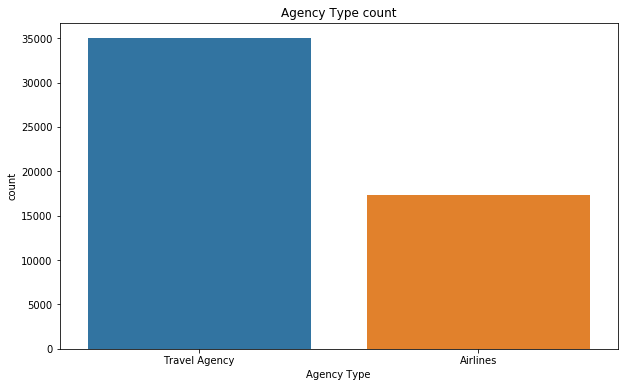

In [56]:
plt.figure(figsize=(10,6))
sns.countplot(df['Agency Type'])
plt.title('Agency Type count')
plt.xlabel('Agency Type')
plt.show()

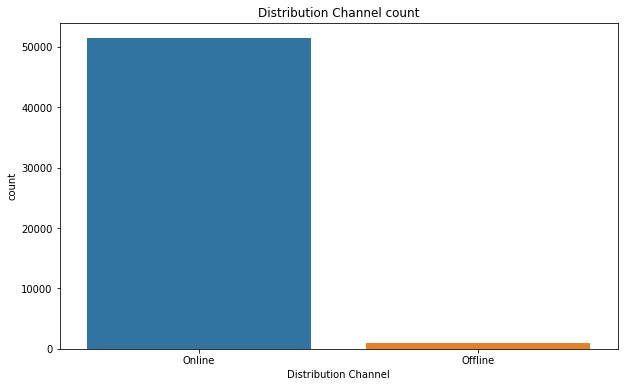

In [57]:
plt.figure(figsize=(10,6))
sns.countplot(df['Distribution Channel'])
plt.title('Distribution Channel count')
plt.xlabel('Distribution Channel')
plt.show()

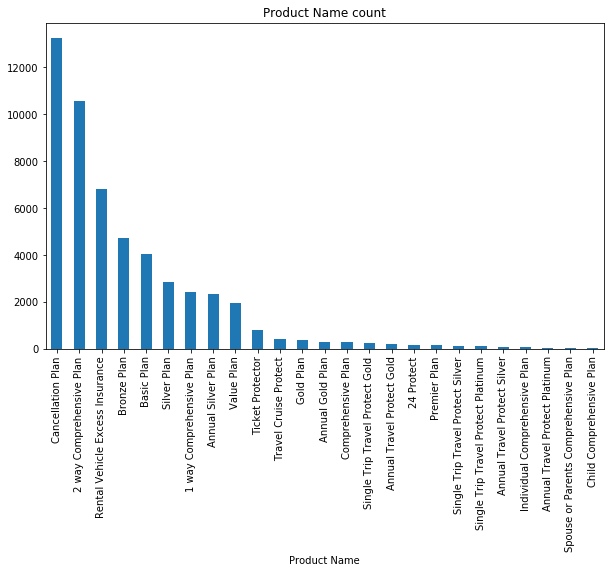

In [58]:
plt.figure(figsize=(10,6))
# sns.countplot(df['Product Name'])
df['Product Name'].value_counts().plot(kind = 'bar')
plt.title('Product Name count')
plt.xlabel('Product Name')
plt.xticks(rotation=90)
plt.show()

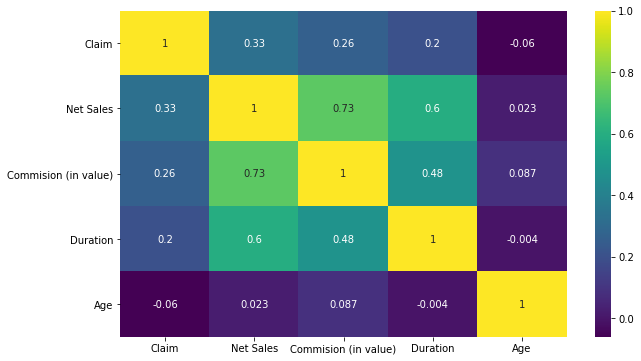

In [59]:
k=10
cols=df.corr().nlargest(k,'Claim')['Claim'].index
cm = df[cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

In [63]:
# Find features with correlation nlargest
for k in range(4,11):
    cols=df.corr().nlargest(k,'Claim')['Claim'].index
    print(len(cols.tolist()),':',cols.tolist())

4 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration']
5 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination']
6 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Distribution Channel']
7 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Distribution Channel', 'Product Name']
8 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Distribution Channel', 'Product Name', 'Age']
9 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Distribution Channel', 'Product Name', 'Age', 'Agency Type']
10 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Distribution Channel', 'Product Name', 'Age', 'Agency Type', 'Agency']


In [60]:
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
    le = LabelEncoder()
    columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
    for feature in columnsToEncode:
        try:
            dataset[feature] = le.fit_transform(dataset[feature])
        except:
            print('Error encoding '+feature)
    return dataset

In [61]:
def SplitData(data):
#     data.drop(columns=['ID'],axis=1,inplace=True)
    # Predictors
    dataframe = data.iloc[:,:-1]
    # Target
    target = data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [62]:
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
# Predictors
X = df.iloc[:,:-1]
# Target
y = df.iloc[:,-1]

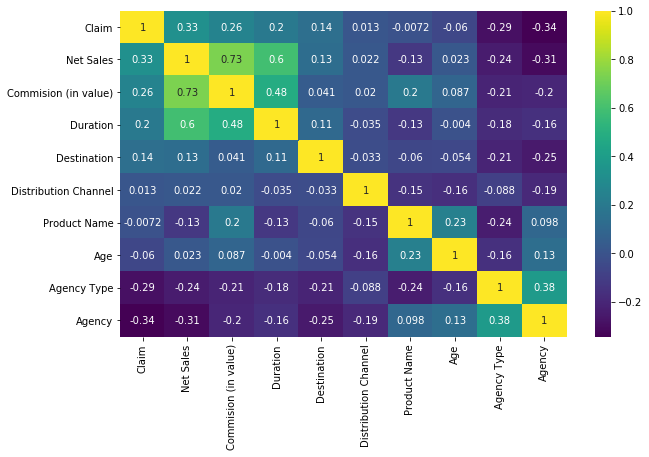

In [65]:
k=10
cols=df.corr().nlargest(k,'Claim')['Claim'].index
cm = df[cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

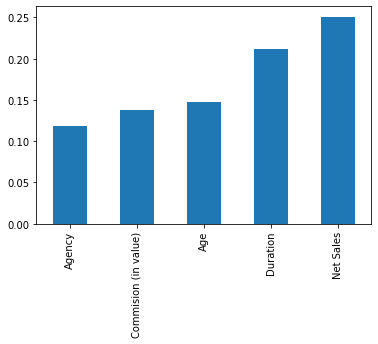

Index(['Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales'], dtype='object')


In [67]:
def rfc_feature_selection(dataset,target):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42, stratify=target)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    rfc_importances = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values().tail(5)
    rfc_importances.plot(kind='bar')
    plt.show()
    print(rfc_importances.index)

rfc_feature_selection(X,y)

## Feature Selection

In [94]:
def feature_selection(predictors,target,number_of_features):
    models = RandomForestClassifier(random_state=42)
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
    print('{} Features to be selected for Model'.format(number_of_features))
    print('===='*30)
    cols = feature_ranking[feature_ranking.values==1].index.tolist()
    return cols


In [101]:
def model_feature_selection(dataset,target,p):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42, stratify=target)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    feature_ranking = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values().tail(p)
    print('{} Features to be selected for Model'.format(p))
#     print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('===='*30)
    cols = feature_ranking.index.tolist()
    return cols



In [95]:
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
# Predictors
X = df.iloc[:,:-1]
# Target
y = df.iloc[:,-1]


In [96]:
col = []
for i in range(len(X.columns)//2,len(X.columns)+1):
    cols = feature_selection(X,y,i)
    print(cols)
    col.append(cols)
col

4 Features to be selected for Model
['Agency', 'Duration', 'Net Sales', 'Commision (in value)']
5 Features to be selected for Model
['Agency', 'Duration', 'Net Sales', 'Commision (in value)', 'Age']
6 Features to be selected for Model
['Agency', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
7 Features to be selected for Model
['Agency', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
8 Features to be selected for Model
['Agency', 'Agency Type', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
9 Features to be selected for Model
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']


[['Agency', 'Duration', 'Net Sales', 'Commision (in value)'],
 ['Agency', 'Duration', 'Net Sales', 'Commision (in value)', 'Age'],
 ['Agency',
  'Duration',
  'Destination',
  'Net Sales',
  'Commision (in value)',
  'Age'],
 ['Agency',
  'Product Name',
  'Duration',
  'Destination',
  'Net Sales',
  'Commision (in value)',
  'Age'],
 ['Agency',
  'Agency Type',
  'Product Name',
  'Duration',
  'Destination',
  'Net Sales',
  'Commision (in value)',
  'Age'],
 ['Agency',
  'Agency Type',
  'Distribution Channel',
  'Product Name',
  'Duration',
  'Destination',
  'Net Sales',
  'Commision (in value)',
  'Age']]

In [102]:
col = []
for i in range(len(X.columns)//2,len(X.columns)+1):
    cols = model_feature_selection(X,y,i)
    print(cols)
    col.append(cols)
col

4 Features to be selected for Model
['Commision (in value)', 'Age', 'Duration', 'Net Sales']
5 Features to be selected for Model
['Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales']
6 Features to be selected for Model
['Destination', 'Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales']
7 Features to be selected for Model
['Product Name', 'Destination', 'Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales']
8 Features to be selected for Model
['Agency Type', 'Product Name', 'Destination', 'Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales']
9 Features to be selected for Model
['Distribution Channel', 'Agency Type', 'Product Name', 'Destination', 'Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales']


[['Commision (in value)', 'Age', 'Duration', 'Net Sales'],
 ['Agency', 'Commision (in value)', 'Age', 'Duration', 'Net Sales'],
 ['Destination',
  'Agency',
  'Commision (in value)',
  'Age',
  'Duration',
  'Net Sales'],
 ['Product Name',
  'Destination',
  'Agency',
  'Commision (in value)',
  'Age',
  'Duration',
  'Net Sales'],
 ['Agency Type',
  'Product Name',
  'Destination',
  'Agency',
  'Commision (in value)',
  'Age',
  'Duration',
  'Net Sales'],
 ['Distribution Channel',
  'Agency Type',
  'Product Name',
  'Destination',
  'Agency',
  'Commision (in value)',
  'Age',
  'Duration',
  'Net Sales']]

In [92]:
def Features_random_forrest_best(dataframe,target):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    auc = roc_auc_score(y_test,y_pred)
    acc = np.round(rfc.score(X_test,y_test)*100,2)
    print('roc_auc_score:',auc)
    print('Accuracy:',acc)
    print("===="*10)

In [93]:
for i in col:
    print("No of Columns:",len(i))
    Features_random_forrest_best(X[i],y)

No of Columns: 4
roc_auc_score: 0.8244947431441719
Accuracy: 91.61
No of Columns: 5
roc_auc_score: 0.8403401184023261
Accuracy: 92.51
No of Columns: 6
roc_auc_score: 0.8579508371270865
Accuracy: 93.12
No of Columns: 7
roc_auc_score: 0.8739133409889352
Accuracy: 93.84
No of Columns: 8
roc_auc_score: 0.8752915337384817
Accuracy: 93.9
No of Columns: 9
roc_auc_score: 0.8760563085957643
Accuracy: 94.0


In [103]:
for i in col:
    print("No of Columns:",len(i))
    Features_random_forrest_best(X[i],y)

No of Columns: 4
roc_auc_score: 0.8373525487851462
Accuracy: 92.53
No of Columns: 5
roc_auc_score: 0.8422546676714401
Accuracy: 92.55
No of Columns: 6
roc_auc_score: 0.8566503203680964
Accuracy: 92.98
No of Columns: 7
roc_auc_score: 0.8752915337384817
Accuracy: 93.9
No of Columns: 8
roc_auc_score: 0.8739130336800052
Accuracy: 93.87
No of Columns: 9
roc_auc_score: 0.8768984521346732
Accuracy: 94.04


## Maximum accuracy with 9 columns

In [39]:
def SelectRegressor(X_train, X_test, y_train, y_test):
    regressors = {
        'Linear Regression' : LinearRegression(),
        'Lasso' : Lasso(),
        'Ridge' : Ridge(),
        'Decision Tree' : DecisionTreeRegressor(),
        'RandomForest Regressor' : RandomForestRegressor(),
        'RandomForest Classifier' : RandomForestClassifier(),
        'XGBoost' : XGBRegressor(),
        'Gradient Boosting':GradientBoostingClassifier()
    }

    results=pd.DataFrame(columns=['AUC','R2-score','Accuracy'])
    for method,func in regressors.items():
        print("==="*10+" "+method+" "+"==="*10)
        func.fit(X_train,y_train)
        pred = func.predict(X_test)
        results.loc[method]= [roc_auc_score(y_test,pred),
                              r2_score(y_test,pred),
                              np.round(func.score(X_test,y_test)*100,2)]
        print("=========="*10) 
    print("Maximum Accuracy with "+str(results[results['Accuracy']==max(results['Accuracy'])].index.tolist()[0])
      +" is "+str(max(results['Accuracy']))+"%")
    return results

In [40]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
def SelectSmote(data):
    # Predictors
    dataframe = data.iloc[:,:-1]
    # Target
    target = data.iloc[:,-1]
    smote = {
        'SMOTE' : SMOTE(),
        'RandomOverSampler' : RandomOverSampler(),
        'SMOTETomek' : SMOTETomek(),
        'NearMiss' : NearMiss()
    }
    X_train, X_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    result=pd.DataFrame(columns=['Accuracy'])
    for method,func in smote.items():
        print("==="*10+" "+method+" "+" And RandomForestClassifier() "+"==="*10)
        X_train, y_train =  func.fit_sample(X_train, y_train)
        rand = RandomForestClassifier()
        rand.fit(X_train,y_train)
        pred = rand.predict(X_test)
        result.loc[method]= [np.round(rand.score(X_test,y_test)*100,2)]
        print("=========="*10) 
    print("Maximum Accuracy for  RandomForestClassifier after balanced data for "
          +str(result[result['Accuracy']==max(result['Accuracy'])].index.tolist()[0])+"technique is "
          +str(max(result['Accuracy']))+"%")
    return result

In [41]:
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)
SelectRegressor_result = SelectRegressor(X_train, X_test, y_train, y_test)
SelectRegressor_result

============================== Linear Regression ==============================
============================== Lasso ==============================
============================== Ridge ==============================
============================== Decision Tree ==============================
============================== RandomForest Regressor ==============================
============================== RandomForest Classifier ==============================
============================== XGBoost ==============================
============================== Gradient Boosting ==============================
Maximum Accuracy with RandomForest Classifier is 93.95%


,AUC,R2-score,Accuracy
Linear Regression,0.791182,0.198580,19.86
Lasso,0.719024,0.100583,10.06
Ridge,0.791161,0.198580,19.86
Decision Tree,0.858383,0.410032,41.00
RandomForest Regressor,0.967238,0.662406,66.24
RandomForest Classifier,0.876363,0.563670,93.95
XGBoost,0.964832,0.622262,62.23
Gradient Boosting,0.674691,0.008841,86.25


In [22]:
SelectSmote_result = SelectSmote(df)
SelectSmote_result

============================== SMOTE  And RandomForestClassifier() ==============================
============================== RandomOverSampler  And RandomForestClassifier() ==============================
============================== SMOTETomek  And RandomForestClassifier() ==============================
============================== NearMiss  And RandomForestClassifier() ==============================
Maximum Accuracy for  RandomForestClassifier after balanced data for SMOTEtechnique is 92.17%


,Accuracy
SMOTE,92.17
RandomOverSampler,92.05
SMOTETomek,91.86
NearMiss,91.87


## After balanced data Accuracy is good with SMOTE, But Before Balancing the accuracy is Good with RandomForest Classifier only

In [19]:
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)

In [20]:
def grid_search_random_forrest(data):
        # Predictors
    X = data.iloc[:,:-1]
    # Target
    y = data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(X_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_

grid_search_random_forrest(df)

Best Parameters are:


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt'}

In [50]:
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)


In [54]:
def RandomForest(X_train, X_test, y_train, y_test):
    rfc_clf=RandomForestClassifier()
    rfc_clf.fit(X_train, y_train)
    pred=rfc_clf.predict(X_test)
    score=np.round(rfc_clf.score(X_test,y_test)*100,2)
    return score

#trainning

score = RandomForest(X_train, X_test, y_train, y_test)    
print('score is:',score)

score is: 93.88


In [53]:
def RandomForest(X_train, X_test, y_train, y_test):
    rfc_clf=RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'sqrt')
    rfc_clf.fit(X_train, y_train)
    pred=rfc_clf.predict(X_test)
    score=np.round(rfc_clf.score(X_test,y_test)*100,2)
    return score

#trainning

score = RandomForest(X_train, X_test, y_train, y_test)    
print('score is:',score)

score is: 86.52


## After Parameter tunning a Accuracy is not good decreases so this weak model boosting

In [63]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.ensemble import AdaBoostRegressor #For Regression
from sklearn.ensemble import GradientBoostingClassifier #For Classification
from sklearn.ensemble import GradientBoostingRegressor #For Regression
def SelectBoost(data):
    # Predictors
    dataframe = data.iloc[:,:-1]
    # Target
    target = data.iloc[:,-1]
    smote = {
        'XGBClassifier' : XGBClassifier(),
        'AdaBoostClassifier' : AdaBoostClassifier(),
        'GradientBoostingClassifier' : GradientBoostingClassifier()
    }
    X_train, X_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    result=pd.DataFrame(columns=['Accuracy'])
    for method,func in smote.items():
        print("==="*10+" "+method+" "+" And RandomForestClassifier() "+"==="*10)
        func.fit(X_train,y_train)
        pred = func.predict(X_test)
        result.loc[method]= [np.round(func.score(X_test,y_test)*100,2)]
        print("=========="*10) 
    print("Maximum Accuracy for  RandomForestClassifier after balanced data for "
          +str(result[result['Accuracy']==max(result['Accuracy'])].index.tolist()[0])+"technique is "
          +str(max(result['Accuracy']))+"%")
    return result

In [64]:
SelectBoost_result = SelectBoost(df)
SelectBoost_result

============================== XGBClassifier  And RandomForestClassifier() ==============================
============================== AdaBoostClassifier  And RandomForestClassifier() ==============================
============================== GradientBoostingClassifier  And RandomForestClassifier() ==============================
Maximum Accuracy for  RandomForestClassifier after balanced data for XGBClassifiertechnique is 92.66%


,Accuracy
XGBClassifier,92.66
AdaBoostClassifier,85.34
GradientBoostingClassifier,86.25


## with XGBClassifier  Boosting score improved so we can go with XGBClassifier  parameter tuning

In [ ]:
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)

In [22]:
def grid_search_XGboost(data):
        # Predictors
    X = data.iloc[:,:-1]
    # Target
    y = data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    xgbc = XGBClassifier()
    param_grid = { 
        'learning_rate' : [0.2,0.4,0.6,0.8,1],
        'max_depth' : [4,6,8],
        'gamma' : [0.5,0.7,0.9],
        'min_child_weight': [3,5,7],
        'scale_pos_weight':[0.1,0.3,0.5],
        'grow_policy':['lossguide']
        }
    grid_search_model = GridSearchCV(xgbc, param_grid=param_grid)
    grid_search_model.fit(X_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_

grid_search_XGboost(df)

Best Parameters are:


{'gamma': 0.7,
 'grow_policy': 'lossguide',
 'learning_rate': 0.8,
 'max_depth': 8,
 'min_child_weight': 5,
 'scale_pos_weight': 0.1}

In [ ]:
xgbc = XGBClassifier(base_estimator=rfc_clf
                     ,random_state=42
                     ,learning_rate=0.8
                     ,gamma=0.7
                     ,max_depth=8
                     ,min_child_weight=5
                     ,scale_pos_weight=0.1
                     ,grow_policy='lossguide')

In [74]:
def XGboost(X_train, X_test, y_train, y_test):
    xgbc = XGBClassifier()
    xgbc.fit(X_train, y_train)
    pred=xgbc.predict(X_test)
    score=np.round(xgbc.score(X_test,y_test)*100,2)
    return score

#trainning
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)
score = XGboost(X_train, X_test, y_train, y_test)    
print('score is:',score)

score is: 92.66


In [26]:
def XGboost(X_train, X_test, y_train, y_test):
    xgbc = XGBClassifier()
    xgbc.fit(X_train, y_train)
    pred=xgbc.predict(X_test)
    score=np.round(xgbc.score(X_test,y_test)*100,2)
    precision=precision_score(y_test,pred)
    return score,precision

#trainning
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)
score,precision = XGboost(X_train, X_test, y_train, y_test)    
print('Score is {} and Precision is {}.'.format(score,precision))

Score is 92.66 and Precision is 0.8143841515934539.


In [29]:
def XGboost(X_train, X_test, y_train, y_test):
    rfc_clf=RandomForestClassifier()
    xgbc = XGBClassifier(base_estimator=rfc_clf
                         ,random_state=42
                         ,learning_rate=0.8
                         ,gamma=0.7
                         ,max_depth=8
                         ,min_child_weight=5
                         ,scale_pos_weight=0.1
                         ,grow_policy='lossguide')
    xgbc.fit(X_train, y_train)
    pred=xgbc.predict(X_test)
    score=np.round(xgbc.score(X_test,y_test)*100,2)
    precision=precision_score(y_test,pred)
    return score,precision

#trainning
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)
score,precision = XGboost(X_train, X_test, y_train, y_test)    
print('Score is {} and Precision is {}.'.format(score,precision))

[00:24:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { base_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Score is 86.96 and Precision is 0.9578606158833063.


In [28]:
def XGboost(X_train, X_test, y_train, y_test):
    rfc_clf=RandomForestClassifier()
    xgbc = XGBClassifier(base_estimator=rfc_clf
                         ,random_state=42
                         ,learning_rate=0.8
                         ,gamma=0.7
                         ,max_depth=8
                         ,min_child_weight=5
                         ,scale_pos_weight=0.1
                         ,grow_policy='lossguide')
    xgbc.fit(X_train, y_train)
    pickle.dump(xgbc, open("model.pkl", "wb"))
    pred=xgbc.predict(X_test)
    precision=precision_score(y_test,pred)
    return precision

#trainning
path = 'data/train.csv'
df = LoadData(path)
df = dummyEncode(df)
X_train, X_test, y_train, y_test = SplitData(df)
precision = XGboost(X_train, X_test, y_train, y_test)    
print('score is:',precision)

[00:20:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { base_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


score is: 0.9578606158833063


In [103]:
# with Learning Rate 0.1
path = 'data/test.csv'
df = LoadData(path)
# Storing the Id column
Id = df[['ID']]
df.drop('ID',1,inplace=True)
test = dummyEncode(df)
# test
#testing function
def prediction(test):
    model = pickle.load(open("model.pkl", "rb"))
    y_pred = model.predict(test)
    return y_pred
y_pred = pd.DataFrame(prediction(test),columns=['Claim']) 
print(y_pred['Claim'].value_counts())
submission = pd.concat([Id,y_pred['Claim']],1)
submission.to_csv('submission.csv',index=False)

0    22418
1        3
Name: Claim, dtype: int64


In [85]:
# with Learning Rate 0.8
path = 'data/test.csv'
df = LoadData(path)
# Storing the Id column
Id = df[['ID']]
df.drop('ID',1,inplace=True)
test = dummyEncode(df)
# test
#testing function
def prediction(test):
    model = pickle.load(open("model.pkl", "rb"))
    y_pred = model.predict(test)
    return y_pred
y_pred = pd.DataFrame(prediction(test),columns=['Claim']) 
print(y_pred['Claim'].value_counts())
submission = pd.concat([Id,y_pred['Claim']],1)
submission.to_csv('submission.csv',index=False)

0    21573
1      848
Name: Claim, dtype: int64
